# <center> Maximum Likelihood Quantum Amplitude Estimation & Accreditation Protocols </center>

    Código basado en el paper "Amplitude Estimation without Phase Estimation" de: Yohichi Suzuki, Shumpei Uno, Rudy Raymond, Tomoki Tanaka, Tamiya Onodera y Naoki Yamamoto, https://doi.org/10.1007/s11128-019-2565-2 y en el protocolo de acreditación descrito en https://arxiv.org/pdf/2103.06603v2.pdf.
    

El enfoque convencional para la estimación de amplitud consiste en utilizar el algoritmo de estimación de fase, el cual conlleva muchas operaciones de amplificación controladas seguidas de una transformada de Fourier en el mundo cuántico. Este procedimiento es difícil de implementar en el escenario actual en el que los recursos cuánticos (procesamiento, qubits...) son límitados.

Próximamente se realizarán dispositivos cuánticos reales con varias centenas de qubits, aunque estos son conocidos como dispositivos cuánticos de escala intermedia ruidosos (NISQ, *Noisy Intermidiate-Scale Quantum*, por sus siglas en inglés) y presentan varias limitaciones prácticas, tanto en el número de operaciones, como en el número de qubits disponibles.

La idea principal es utilizar la estimación de máxima verosimilitud (Maximum Likelihood Estimation) basada en datos de medición producidos por circuitos cuánticos con diferentes números de operaciones. De ahí el nombre del Algoritmo - **MLQAE**

#### En primer lugar, realizaremos un experimento analítico
Un ejemplo simple para encontrar un resultado de forma "tradicional". La integral en un intervalo del $sin(x)$ al cuadrado

$I = \frac{1}{b_{\text{max}}} \int_{0}^{b_{\text{max}}} \sin(x)^2 \, dx$. Que, en el mundo discreto se aproxima como: 

$S = \sum_{x=0}^{2^n-1} p(x) \sin^2\left(\frac{(x + \frac{1}{2}) \cdot b_{\text{max}}}{2^n}\right)$

en donde $p(x) = \frac{1}{2^n}$ es una distribución discreta uniforme de probabilidad.

In [1]:
import numpy as np #este import es el único que necesitamos para "explicar" esta parte

# definimos la función para realizar la integral del seno^2 
def sin_integral(upper_lim: float) -> float:
    res_continuo = (upper_lim / 2.0 - np.sin(2 * upper_lim) / 4.0)
    
    return res_continuo/upper_lim

#definimos la función para realizar la suma discretizada del seno^2.
def sin_discrete_sum(upper_lim: float, bits_number: int) -> float:
    n_dis = 2**bits_number
    res_discreto = 0.0
    
    for ii in range(n_dis):
        res_discreto += np.sin(upper_lim / n_dis * (ii + (1/2)))**2
        
    res_discreto = res_discreto / n_dis
    return res_discreto

b_max = np.pi / 4
n_bits = 2 #q-bits

mundo_continuo = sin_integral(b_max)
print("El resultado en el mundo continuo es: " + str(mundo_continuo))


mundo_discreto = sin_discrete_sum(b_max, n_bits)
print("El resultado en el mundo discreto es: " + str(mundo_discreto))

El resultado en el mundo continuo es: 0.1816901138162093
El resultado en el mundo discreto es: 0.1796355690323117


## Inicialización del entorno cuántico

In [2]:
!pip install qiskit.ignis

  Using cached qiskit_ignis-0.7.1-py3-none-any.whl (198 kB)

[notice] A new release of pip available: 23.1.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [3]:
# Importamos las librearías: 

from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit #necesaria para crear bits, qubits y circuitos
from qiskit import execute #necesaria para dar la orden de ejecución
from qiskit import IBMQ #necesaria para llamar a la plataforma IBM Quantum
from qiskit import Aer #necesaria para importar simuladores cuánticos o lanzar ejecuciones en ordenadores reales
from qiskit.providers.ibmq import least_busy
from qiskit.providers.aer.noise import NoiseModel
from scipy import optimize #optimización matmática --> encontrar el valor = 0 (utilizo opmtimize.brute)
from qiskit_ibm_provider import IBMProvider
from qiskit.providers.aer.noise.errors.standard_errors import depolarizing_error
from qiskit.ignis.verification.accreditation import AccreditationFitter, AccreditationCircuits
from qiskit.circuit.library import U1Gate, U2Gate, U3Gate


import sys, time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

IBMProvider.save_account(token="d83e53dfa62683e4eb3ed49770c00c03322d6c921625a94e55cb84c76414b00d915b95732b9e00f1f7502809a7575326ab91316d0eac89acebfd88cc52e483aa", overwrite=True)

print("Realizar simulación en ordenador real o en simulador?")
#job_type = str(input())
job_type = "REAL"


while job_type.upper() not in {"REAL", "SIMULADOR"}:
    print("Por favor, introduce un parámetro válido -> real / simulador")
    job_type = str(input())


if job_type.upper() == "REAL":
    #en caso de querer realizar una ejecución en un ordenador cuántico tenemos dos posibilidades, EXTERNO o CSIC (cátedra UAM / IBM)
    acceso = "EXTERNO"
    Backend_qubits = 20
    print("Acceso seleccionado: "+acceso)
else:
    None


if job_type.upper() == "SIMULADOR":
    provider = IBMProvider()
    backend = Aer.get_backend('qasm_simulator')
    print("Simulador configurado correctamente: "+str(backend))
else:
    if acceso == 'CSIC' :
        # number of qubits to represent the uncertainty ***********************************************************************************************************
        numero_de_qbits_de_incertidumbre = 3
        #**********************************************************************************************************************************************************
        provider = IBMProvider(hub='ibm-q-csic')
        provider.backends()
        backend = least_busy(provider.backends(filters=lambda b: b.configuration().n_qubits >= Backend_qubits and
        not b.configuration().simulator and b.status().operational==True))
        print (backend)
        sistema_cuantico = str(backend)
        print("El programa se ejecutará en: "+str(sistema_cuantico))
        print (sistema_cuantico)
    
    else :
        # number of qubits to represent the uncertainty ***********************************************************************************************************
        numero_de_qbits_de_incertidumbre = 3
        #**********************************************************************************************************************************************************
        # Loading your IBM Quantum account(s)
        provider = IBMProvider()
        """
        Dejo comentado el código a continuación por si quiero volver a realizar TODAS las ejecuciones en un mismo ordenador
        """
        #sistema_cuantico = 'ibmq_manila'
        #backend = provider.get_backend(sistema_cuantico)
        #print("El programa se ejecutará en: "+str(sistema_cuantico))
        #provider.backends()
        #print("The available backends are: "+str(provider.backends()))
        #backend = least_busy(provider.backends(filters=lambda x: x.configuration().simulator == False and x.status().operational == True))
        #print("Por como están de ocupados los ordenadores cuánticos, el programa se ejecutará en: "+str(backend))
        sistema_cuantico = 'ibmq_manila'
        backend = provider.get_backend(sistema_cuantico)


/tmp/ipykernel_60/1108157381.py:12: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.verification.accreditation import AccreditationFitter, AccreditationCircuits


Realizar simulación en ordenador real o en simulador?
Acceso seleccionado: EXTERNO


## Creación de operadores del algoritmo de Grover y circuito de Amplificación de Amplitud (QAA).

Comenzamos por la inicialización del circuito, un estado "uniforme" sencillo de preparar ${P}$. Representado en el circuito por puertas Hadamard para crear una distribución de probablidad uniforme. 

### Introducción al algoritmo de Grover

El algoritmo de Grover utiliza el operador de Grover $\mathcal{Q}$ para amplificar las amplitudes de los estados buenos:

$$
\mathcal{Q} = \mathcal{A}\mathcal{S_0}\mathcal{A}^\dagger \mathcal{S_f}
$$

Aquí,
- $\mathcal{A}$ es el estado de búsqueda inicial para el algoritmo, que consiste en Hadamards, $H^{\otimes n}$ para la búsqueda de Grover clásica, pero puede ser más elaborado para la amplificación de amplitud.
- $\mathcal{S_0}$ es la reflexión sobre el estado todo 0:

$$
|x\rangle \mapsto \begin{cases} -|x\rangle, &x \neq 0 \\ |x\rangle, &x = 0\end{cases}
$$

- $\mathcal{S_f}$ es el oráculo que aplica:

$$
|x\rangle \mapsto (-1)^{f(x)}|x\rangle
$$

   donde $f(x)$ es 1 si $x$ es un estado bueno y 0 en caso contrario.

En resumen, el algoritmo de Grover aplica diferentes potencias de $\mathcal{Q}$ y después de cada ejecución verifica si se ha encontrado una solución buena.

### Ejecutando el algoritmo de Grover

Para ejecutar el algoritmo de Grover, qiskit tiene su propia clase, en este código definimos una función más abajo que nos permite ganar independencia frente a las actualizaciones que vayan surgiendo. 

In [4]:
def P(qc, qx):
    """
        Generación de ua distribución de probablidad uniforme
            qc: quantum circuit
            qx: quantum register
            nbit: number of qubits
    """
    qc.h(qx[:-1])

def A(qc, qx, qx_measure, nbit, b_max):
    """
        Preparación del estado, integral de f()
            qc: quantum circuit
            qx: quantum register
            qx:measure: quantum register for measurement
            nbit: number of qubits
            b_max: upper limit of integral            
    """
    qc.ry(b_max / 2**nbit * 2 * 0.5, qx_measure[-1])
    
    for i in range(nbit):
        qc.cry(2**i * b_max / 2**nbit * 2, qx[nbit-1-i], qx_measure[-1])
               
        
def Ainv(qc, qx, qx_measure, nbit, b_max):
    """
        Puerta inversa de A
            qc: quantum circuit
            qx: quantum register
            qx_measure : quantum register for measurement
            nbit: number of qubits
            b_max: upper limit of integral
    """
    for i in range(nbit)[::-1]:
        qc.cry(-2**i * b_max / 2**nbit * 2, qx[nbit-1-i], qx_measure[-1])
     
    qc.ry(-b_max / 2**nbit * 2 * 0.5, qx_measure[-1])

def multi_control_NOT(qc, qx, qx_measure, qx_ancilla, nbit):    
    """
        Creación de la puerta cuántica multi control NOT. 
            qc: circuito cuántico
            qx: registro
            qx_measure: registro sobre el que realizaremos la medida
            qx_ancilla: bit ancilla de control. 
            nbit: number of qubits
    """

    if nbit == 1:
        qc.cz(qx[0], qx_measure[-1])
        
    elif nbit == 2:
        qc.h(qx_measure[-1])
        qc.ccx(qx[0], qx[1], qx_measure[-1])
        qc.h(qx_measure[-1])
        
    elif nbit > 2.0:
        qc.ccx(qx[0], qx[1], qx_ancilla[0])
        
        for i in range(nbit - 3):
            qc.ccx(qx[i + 2], qx_ancilla[i], qx_ancilla[i + 1])
            
        qc.h(qx_measure[-1])
        qc.ccx(qx[nbit - 1], qx_ancilla[nbit - 3], qx_measure[-1])
        qc.h(qx_measure[-1])
        
        for i in range(nbit - 3)[::-1]:
            qc.ccx(qx[i + 2], qx_ancilla[i], qx_ancilla[i + 1])
            
        qc.ccx(qx[0], qx[1], qx_ancilla[0])


#def reflect(qc, qx, qx_measure, qx_ancilla, nbit, b_max):        
def S_0(qc, qx, qx_measure, qx_ancilla, nbit):
    """
        Operador de reflexion (I - 2|0><0|). Hacemos la reflexión sobre el eje del vector complejo
            qc: quantum circuit
            qx: quantum register
            qx_measure: quantum register for measurement
            qx_ancilla: temporal quantum register for decomposing multi controlled NOT gate
            nbit: number of qubits
            b_max: upper limit of integral
    """
    qc.barrier()
    for i in range(nbit):
        qc.x(qx[i])
    
    qc.x(qx_measure[-1])
    #multi_control_NOT(qc, qx, qx_measure, qx_ancilla, nbit, b_max)
    multi_control_NOT(qc, qx, qx_measure, qx_ancilla, nbit)
    qc.x(qx_measure[-1])
    
    for i in range(nbit):
        qc.x(qx[i])
    
    qc.barrier()

# This is to implement Grover Operator Q
def Q(qc, qx, qx_measure, qx_ancilla, nbit, b_max):
    """
        El operador de Grover
            qc: quantum circuit
            qx: quantum register
            qx_measure: quantum register for measurement
            qx_ancilla: temporal quantum register for decomposing multi controlled NOT gate
            nbit: number of qubits
            b_max: upper limit of integral
    """
    qc.z(qx_measure[-1])
    qc.barrier()
    
    Ainv(qc, qx, qx_measure, nbit, b_max)
    qc.barrier()
    P(qc, qx)

    S_0(qc, qx, qx_measure, qx_ancilla, nbit)
    P(qc, qx)
    qc.barrier()
    A(qc, qx, qx_measure, nbit, b_max)    

### Creación del circuito de grover

In [5]:
def create_grover_circuit(number_grover_list, nbit, b_max):
    """
        To generate quantum circuits running Grover operators with number of iterations in number_grover_list
            numebr_grover_list: list of number of Grover operators
            nbit: number of qubits (2**nbit = ndiv is the number of discretization in the Monte Carlo integration)
            b_max: upper limit of integral
        Return:
            qc_list: quantum circuits with Grover operators as in number_grover_list
    """
    qc_list = []
    
    for igrover in range(len(number_grover_list)):
        
        qx = QuantumRegister(nbit+1, "q")
        #qx_measure = QuantumRegister(1)
        cr = ClassicalRegister(1)
        if (nbit > 2):
            qx_ancilla = QuantumRegister(nbit - 2, "ancilla")
            qc = QuantumCircuit(qx, qx_ancilla, cr)
        else:
            qx_ancilla = 0
            qc = QuantumCircuit(qx, cr)
            
        P(qc, qx)
        qc.barrier()
        A(qc, qx, qx, nbit, b_max)
        qc.barrier()
        
        for ii in range(number_grover_list[igrover]):
            Q(qc, qx, qx, qx_ancilla, nbit, b_max)
        
        qc.measure(qx[-1], cr[0])
        
        qc_list.append(qc)
        
        
    return qc_list

## Mostramos el circuito

In [6]:
qc_list = create_grover_circuit([1], n_bits, b_max)

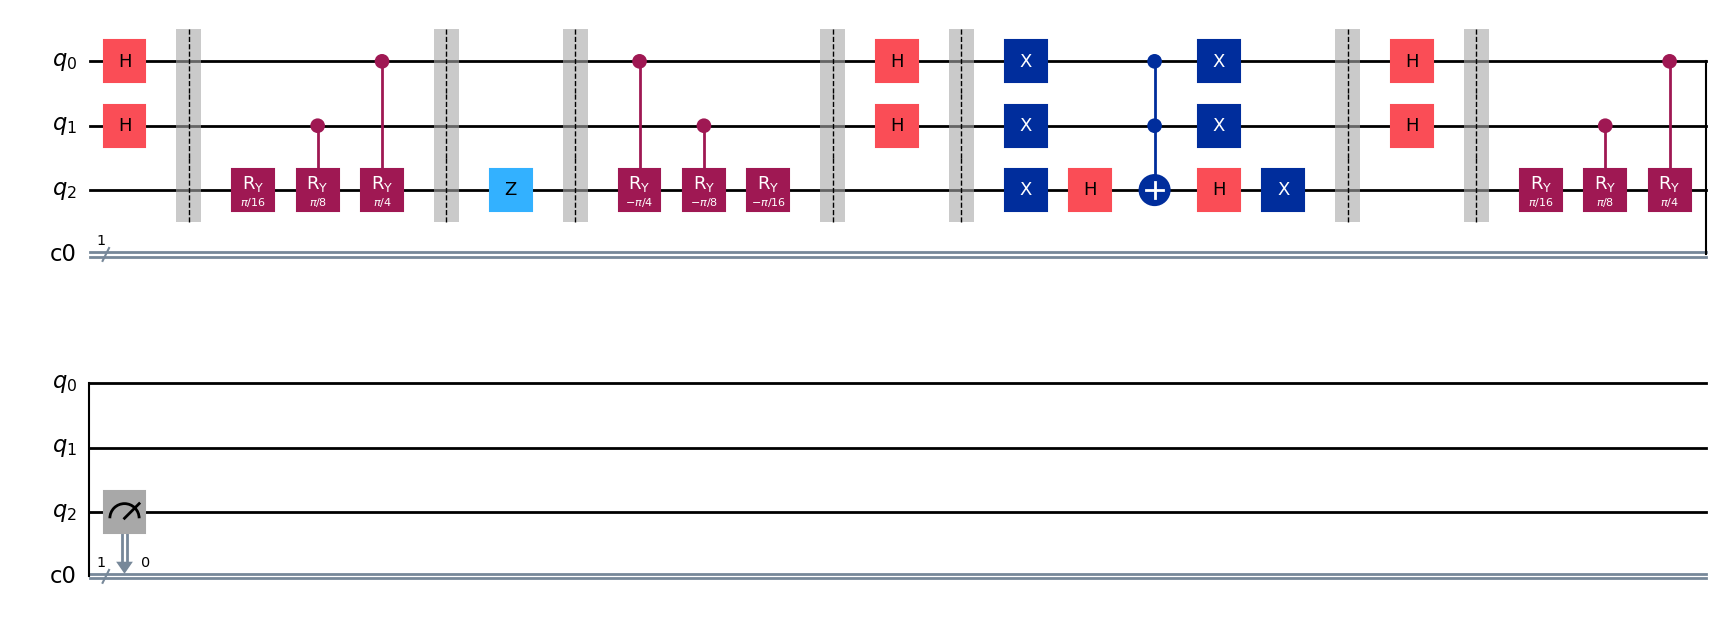

In [7]:
qc_list[0].draw("mpl", style="iqx")

## Y ahora creamos una función auxiliar para poder ejecutar "listas" de circuitos cuánticos
- Esta funcion nos da flexibilidad a la hora de incrementar la potencia de $Q$ (meter varios operadores Grover)### Necesitamos una función para ejecutar los circuitos que nos devuelve la función anterior.

In [8]:
def run_accreditation_protocol(qc): 
    
    #print("---- x ---- Accreditation Protocol Initialised ---- x ----")
    
    accsys = AccreditationCircuits(qc)
    num_traps = 10
    acc_num = 20
    vd_theta = 0.05
    
    #noise_model = NoiseModel()
#
    #p1q = 0.0003
    #noise_model.add_all_qubit_quantum_error(depolarizing_error(p1q, 1), 'u1')
    #noise_model.add_all_qubit_quantum_error(depolarizing_error(p1q, 1), 'u2')
    #noise_model.add_all_qubit_quantum_error(depolarizing_error(p1q, 1), 'u3')
    #p2q = 0.003
    #noise_model.add_all_qubit_quantum_error(depolarizing_error(p2q, 2), 'cx')

    basis_gates = [U1Gate, U2Gate, U3Gate, "cx", "id", "x", "y", "z", "h", "s", "sdg", "t", "tdg", "rx", "ry", "rz"]
    
    acc_list = []
    acc_conf_list = []
    acc_vd_list = []
    num_traps_list = []
    
    #fijamos un mínimo de 4 dado que el protocolo de acreditaónci no funciona con menos de 3 circuitos trampa
    for trap in range(4, num_traps+1):
        
        fit = AccreditationFitter()
        
        for run in range(acc_num+1):
            circuit_list, postp_list, v_zero = accsys.generate_circuits(trap)
            #job = execute(circuit_list, backend, noise_model=noise_model, basis_gates=basis_gates, shots=1)
            job = execute(circuit_list, backend, basis_gates=basis_gates, shots=1)
            result = job.result()
            
            fit.single_protocol_run(result, postp_list, v_zero)
        
        #print("\nWith", trap,
        #      "traps, AP accepted", fit.N_acc,
        #      "out of", fit.num_runs, "times.")
        
        acc_list.append(fit.N_acc)
        
        fit.bound_variation_distance(vd_theta)
        
        #print("With confidence", fit.confidence,
        #      "AP with", trap,
        #      "traps certifies that VD is upper-bounded by", fit.bound)
        
        acc_conf_list.append(fit.confidence)
        acc_vd_list.append(fit.bound)
        num_traps_list.append(trap)
        
    #print("---- x ---- Accreditation Protocol Finished ---- x ----")
    
    return acc_list, acc_conf_list, acc_vd_list, num_traps_list
    
    

def run_grover(qc_list, number_grover_list, shots_list, backend):
    """
        Run the quantum circuits returned by create_grover_circuit()
            qc_list: list of quantum circuits
            numebr_grover_list: list of number of Grover operators
            shots_list:  list of number of shots
            backend: name of backends
        
        Return:
            hit_list: list of count of obserbving "1" for qc_list
    """
    
    hit_list = []
    acc_result_df = pd.DataFrame()
    for k in range(len(number_grover_list)):
        job = execute(qc_list[k], backend=backend, shots=shots_list[k])
        
        lapse = 0
        interval = 0.00001
        
        time.sleep(interval)
        
        while job.status().name != 'DONE':
            time.sleep(interval)
            lapse += 1
        
        counts = job.result().get_counts(qc_list[k]).get("1", 0)
        
        hit_list.append(counts)
        
        acc_list, acc_conf_list, acc_vd_list, num_traps_list = run_accreditation_protocol(qc_list[k])
        
        acc_df = pd.DataFrame({"n_acceptance":acc_list,
                            "acc_confidence":acc_conf_list, "acc_variation_distance":acc_vd_list,
                            "acc_num_traps":num_traps_list})
    
        acc_df["n_grovers"] = number_grover_list[k]

        acc_result_df = pd.concat((acc_result_df, acc_df), axis=0)

    return hit_list, acc_result_df


### Etapa de post procesado
#### En esta etapa consegimos obtener nuestro propio $theta$

La función de postprocesamiento combina los resultados de ejecutar circuitos de Grover con varias  iteraciones aplicando MLE. Supongamos que ejecutamos los operadores de Grover ($Q$) ${m_0, m_1,...,m_M}$ veces y, para cada ejecución, lo repetimos $N_k$ veces, de las cuales observamos $h_k$ veces estados "buenos". Dado que la probabilidad de observar estados "buenos" es $\sin^2((2m_k+1)\theta_a)$, la verosimilitud (*likelihood*) de observar $h_k$ veces estados "buenos" es: $L(h, \theta)$

Utilizamos el límite inferior de cramer.rao (ver referencia en: [paper QAE del Google Drive]).


In [9]:
def CalcErrorCramerRao(M, shot_list, p0, number_grover_list):
    """
        calculate Cramér-Rao lower bound
            M: upper limit of the sum in Fisher information 
            shots_list:  list of number of shots
            p0: the true parameter value to be estimated
            numebr_grover_list: list of number of Grover operators        

        Return:
            square root of Cramér-Rao lower bound:  lower bound on the standard deviation of unbiased estimators
    """
    FisherInfo = 0
    for k in range(M + 1):
        Nk = shot_list[k]
        mk = number_grover_list[k]
        FisherInfo += Nk / (p0 * (1 - p0)) * (2 * mk + 1)**2
    return np.sqrt(1 / FisherInfo)



def calculate_theta(hit_list, number_grover_list, shots_list):
    """
        calculate optimal theta values
            hit_list: list of count of obserbving "1" for qc_list
            numebr_grover_list: list of number of Grover operators        
            shots_list: list of number of shots

        Return:
            thetaCandidate_list: list of optimal theta
    """

    small = 1.e-15  # small valued parameter to avoid zero division
    confidenceLevel = 5  # confidence level to determine the search range

    thetaCandidate_list = []
    a_candidate_list = []
    grover_list = []
    rangeMin = 0.0 + small
    rangeMax = 1.0 - small
    for igrover in range(len(number_grover_list)): #entramos en este bucle utilizando la potencia de grover, no el número (i,e,. 0,1,2,3....)

        def loglikelihood(p):
            ret = 0.0
            theta = np.arcsin(np.sqrt(p))
            
            for n in range(igrover + 1):
                ihit = hit_list[n]
                arg = (2 * number_grover_list[n] + 1) * theta
                ret = ret + 2 * ihit * np.log(np.abs(np.sin(arg))) + 2 * (
                    shots_list[n] - ihit) * np.log(np.abs(np.cos(arg)))
            return -ret

        searchRange = [rangeMin, rangeMax]
        searchResult = optimize.brute(loglikelihood, ranges=[searchRange], finish=None)
        a_candidate = searchResult
        a_candidate_list.append(a_candidate)
        thetaCandidate_list.append(np.arcsin(np.sqrt(a_candidate)))
        grover_list.append(number_grover_list[igrover])
        perror = CalcErrorCramerRao(igrover, shots_list, a_candidate, number_grover_list)
        rangeMax = min(a_candidate+confidenceLevel*perror,1.0-small)
        rangeMin = max(a_candidate-confidenceLevel*perror,0.0+small)

        
        
    return thetaCandidate_list, grover_list, a_candidate_list

In [10]:
def CalcNumberOracleCalls(M, shot_list, number_grover_list):
    """
        calculate the total number of oracle calls
            M: numero de grovers 
            shots_list:  list of number of shots
            numebr_grover_list: list of number of Grover operators        

        Return:
            Norac: the total number of oracle calls
    """
    
    Norac = 0
    for k in range(M + 1):
        Nk = shots_list[k]
        mk = number_grover_list[k]
        Norac += Nk * (2 * mk + 1)
            
    return Norac

In [11]:
def define_shots_list(shot_run, number_grover_list):
    shots_list = []
    for grover in number_grover_list:
        shots_list.append(shot_run)
        
    return shots_list

## Ejecución de nuestro algoritmo en simuladores. 

In [12]:
final_result_df = pd.DataFrame()
result_df = pd.DataFrame()
acc_final_df = pd.DataFrame()
results_list = []

error_list = []
shots_list = []  # list of number of shots
#number_grover_list = [0, 1, 2, 4]  # list of number of Grover operators
#shots_run = [32, 64, 128, 256, 512, 1024]
number_grover_list = [4]  # list of number of Grover operators
shots_run = [1024]

for shot in shots_run:
    shots_list = define_shots_list(shot, number_grover_list)
    qc_list = create_grover_circuit(number_grover_list, n_bits, b_max)  # list of Grover circuits
    hit_list, acc_result_df = run_grover(qc_list, number_grover_list, shots_list, backend)  # list of number of grover operators
    theta_candidate_list, grover_number_list, a_candidate_list = calculate_theta(hit_list, number_grover_list, shots_list)  # list of estimated theta values
    error_list = list(np.abs(mundo_discreto - np.sin(theta_candidate_list)**2)/mundo_discreto)
    
    result_df = pd.DataFrame({"n_grovers":grover_number_list, "theta_candidate":theta_candidate_list,
                            "a_candidate":a_candidate_list, "rel_error":error_list})
    
    result_df["n_shots"] = shot
    
    acc_final_df = pd.concat((acc_final_df, acc_result_df), axis=0)
    final_result_df = pd.concat((final_result_df, result_df), axis=0)

final_result_df.reset_index(drop = True)

Traceback (most recent call last):
  Cell In[12], line 16
    hit_list, acc_result_df = run_grover(qc_list, number_grover_list, shots_list, backend)  # list of number of grover operators
  Cell In[8], line 91 in run_grover
    acc_list, acc_conf_list, acc_vd_list, num_traps_list = run_accreditation_protocol(qc_list[k])
  Cell In[8], line 35 in run_accreditation_protocol
    result = job.result()
  File /opt/conda/lib/python3.10/site-packages/qiskit_ibm_provider/job/ibm_circuit_job.py:250 in result
    raise IBMJobFailureError(f"Job failed: " f"{error_message}")
IBMJobFailureError: 'Job failed: Instruction rx is not supported'

Use %tb to get the full traceback.


In [ ]:
acc_final_df.to_csv(r"../../Output/MLQAE_ACCREDITED_vFin_results_REAL_QASM.csv")
final_result_df.to_csv(r"../../Output/MLQAE_ACCREDITED_vFin_results_REAL_QASM_1.csv")

In [ ]:
error_0_grover = final_result_df[final_result_df["n_grovers"] == 0]
error_1_grover = final_result_df[final_result_df["n_grovers"] == 1]
error_2_grover = final_result_df[final_result_df["n_grovers"] == 2]
error_4_grover = final_result_df[final_result_df["n_grovers"] == 4]


figure_1 = plt.figure()

#plt.plot(error_0_grover["n_shots"], error_0_grover["rel_error"], "-^")
#plt.plot(error_1_grover["n_shots"], error_1_grover["rel_error"], "-^")
#plt.plot(error_2_grover["n_shots"], error_2_grover["rel_error"], "-^")
plt.plot(error_4_grover["n_shots"], error_4_grover["rel_error"], "-^")

plt.ylim(0, 2)
plt.xlabel("Number of shots")
plt.ylabel("Relative Error")
#plt.legend(["Q = 1", "Q = 2", "Q = 3", "Q = 4"])

plt.show()




In [17]:
final_result_df = pd.DataFrame()
result_df = pd.DataFrame()
acc_final_df = pd.DataFrame()
results_list = []

error_list = []
shots_list = []  # list of number of shots
#number_grover_list = [0, 1, 2, 4]  # list of number of Grover operators
#shots_run = [32, 64, 128, 256, 512, 1024]
number_grover_list = [0, 1, 2, 4]  # list of number of Grover operators
shots_run = [32, 64, 128, 256, 512, 1024]

n_exec = 10

for ii in range(n_exec):
    for shot in shots_run:
        sys.stdout.write("n_trial=(%d/%d)\r" % ((ii + 1), n_exec))
        sys.stdout.flush()
        shots_list = define_shots_list(shot, number_grover_list)
        qc_list = create_grover_circuit(number_grover_list, n_bits, b_max)  # list of Grover circuits
        hit_list, acc_result_df = run_grover(qc_list, number_grover_list, shots_list, backend)  # list of number of grover operators
        theta_candidate_list, grover_number_list, a_candidate_list = calculate_theta(hit_list, number_grover_list, shots_list)  # list of estimated theta values
        error_list = list(np.abs(mundo_discreto - np.sin(theta_candidate_list)**2)/mundo_discreto)
        result_df = pd.DataFrame({"n_grovers":grover_number_list, "theta_candidate":theta_candidate_list,
                                "a_candidate":a_candidate_list, "rel_error":error_list})

        result_df["n_shots"] = shot
        result_df["execc_index"] = ii+1
        result_df["analytical_result"] = mundo_discreto

        acc_final_df = pd.concat((acc_final_df, acc_result_df), axis=0)
        final_result_df = pd.concat((final_result_df, result_df), axis=0)

final_result_df.reset_index(drop = True)

/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance i

/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance i

/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance i

/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance i

/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance i

/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance i

/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance i

/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance i

/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance i

/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance i

/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance i

/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance i

/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance i

/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance i

/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance i

/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance i

/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance i

/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance i

/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance i

/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance i

/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance i

/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance i

/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance i

/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance i

/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance i

/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance i

/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance i

/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance i

/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance i

/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance i

/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance i

/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance i

/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance i

/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance i

/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance i

/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance i

/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance i

/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance i

/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance i

/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance i

/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance i

/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance i

/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance i

/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance i

/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance i

/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance i

/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance i

/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance i

/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance i

/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance i

/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance i

/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance i

/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance i

/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance i

/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance i

/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance i

/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance i

/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance i

/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance i

/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  fit.bound_variation_distance(vd_theta)
/tmp/ipykernel_62/465714373.py:36: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  fit.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_62/465714373.py:44: DeprecationWarning: bound_variation_distance i

,n_grovers,theta_candidate,a_candidate,rel_error,n_shots,execc_index,analytical_result
0,0,0.408638,0.157895,0.121027,32,1,0.179636
1,1,0.434120,0.176914,0.015149,32,1,0.179636
2,2,0.426717,0.171301,0.046399,32,1,0.179636
3,4,0.446054,0.186114,0.036065,32,1,0.179636
4,0,0.330423,0.105263,0.414018,64,1,0.179636
...,...,...,...,...,...,...,...
235,4,0.438463,0.180241,0.003371,512,10,0.179636
236,0,0.408638,0.157895,0.121027,1024,10,0.179636
237,1,0.444471,0.184883,0.029212,1024,10,0.179636
238,2,0.440558,0.181854,0.012352,1024,10,0.179636


In [19]:
acc_final_df.to_csv(r"../../Output/MLQAE_ACCSYS_vFin_results_SIM_QASM_10.csv")

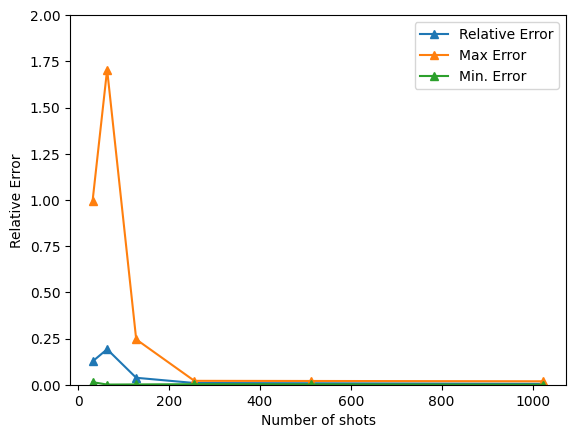

In [22]:
mean_error_1_grover = pd.DataFrame(final_result_df[final_result_df["n_grovers"] == 1].groupby(["n_shots", "n_grovers"])["rel_error"].mean().reset_index())
mean_error_2_grover = pd.DataFrame(final_result_df[final_result_df["n_grovers"] == 2].groupby(["n_shots", "n_grovers"])["rel_error"].mean().reset_index())
mean_error_4_grover = pd.DataFrame(final_result_df[final_result_df["n_grovers"] == 4].groupby(["n_shots", "n_grovers"])["rel_error"].mean().reset_index())
max_error_4_grover = pd.DataFrame(final_result_df[final_result_df["n_grovers"] == 4].groupby(["n_shots", "n_grovers"])["rel_error"].max().reset_index())
min_error_4_grover = pd.DataFrame(final_result_df[final_result_df["n_grovers"] == 4].groupby(["n_shots", "n_grovers"])["rel_error"].min().reset_index())

figure_1 = plt.figure()

#plt.plot(mean_error_1_grover["n_shots"], mean_error_1_grover["rel_error"], "-^")
#plt.plot(mean_error_2_grover["n_shots"], mean_error_2_grover["rel_error"], "-^")
#plt.plot(mean_error_4_grover["n_shots"], mean_error_4_grover["rel_error"], "-^")
plt.plot(mean_error_4_grover["n_shots"], mean_error_4_grover["rel_error"], "-^")
plt.plot(max_error_4_grover["n_shots"], max_error_4_grover["rel_error"], "-^")
plt.plot(min_error_4_grover["n_shots"], min_error_4_grover["rel_error"], "-^")


plt.ylim(0,2)
plt.xlabel("Number of shots")
plt.ylabel("Relative Error")
plt.legend(["Relative Error", "Max Error", "Min. Error"])

plt.show()
final_result_df.to_csv(r"../../Output/MLQAE_vFin_results_SIM_QASM_10_v2.csv")

In [283]:
for grover_circuit, mlqae_circuit in enumerate(qc_list):
    print("Showing information for: "+str(number_grover_list[grover_circuit]))
    print("Puertas = ", mlqae_circuit.count_ops())
    print("Profundidad / Depth = ", mlqae_circuit.depth())
    print("---- X ----")

Showing information for: 0
Puertas =  OrderedDict([('h', 2), ('barrier', 2), ('cry', 2), ('ry', 1), ('measure', 1)])
Profundidad / Depth =  5
---- X ----
Showing information for: 1
Puertas =  OrderedDict([('h', 8), ('barrier', 7), ('cry', 6), ('x', 6), ('ry', 3), ('z', 1), ('ccx', 1), ('measure', 1)])
Profundidad / Depth =  19
---- X ----
Showing information for: 2
Puertas =  OrderedDict([('h', 14), ('barrier', 12), ('x', 12), ('cry', 10), ('ry', 5), ('z', 2), ('ccx', 2), ('measure', 1)])
Profundidad / Depth =  33
---- X ----
Showing information for: 4
Puertas =  OrderedDict([('h', 26), ('x', 24), ('barrier', 22), ('cry', 18), ('ry', 9), ('z', 4), ('ccx', 4), ('measure', 1)])
Profundidad / Depth =  61
---- X ----
